<img src="https://gist.githubusercontent.com/nesnoj/6ee605cd3494fa6e3e848385c4afbe19/raw/a883b1bdc69c0c5bbb0b00ba92f43033aa86ec64/dingo_model.png" alt="DINGO Model" width="800"  align="center">

In [1]:
%%capture

from ding0.core import NetworkDing0
from ding0.tools.logger import setup_logger
from ding0.tools.results import save_nd_to_pickle
from ding0.tools.plots import plot_mv_topology
from egoio.tools import db
from sqlalchemy.orm import sessionmaker
import oedialect

from ding0.tools import results # to load pickl file


# create new network
nd = NetworkDing0(name='network')


# set ID of MV grid district
mv_grid_districts = [40] # fn

In [2]:
import osmnx as ox

import networkx as nx 

import pandas as pd
from sqlalchemy import func              
from geoalchemy2.shape import to_shape 


from shapely.geometry import Point, Polygon, LineString



import folium

In [3]:
from config.config_lv_grids_osm import get_config_osm
from config.db_conn_local import create_session_osm 

from grid.lv_grid.routing import build_graph_from_ways, \
get_location_substation_at_pi, subdivide_graph_edges

from grid.lv_grid.parameterization import parameterize_by_load_profiles
#from grid.lv_grid.clustering import 

from grid.lv_grid.geo import get_Point_from_x_y, get_points_in_load_area, \
get_convex_hull_from_points

#### SET DING0 SETTINGS

In [4]:
# TODO set in config file
ding0_default=False
retain_all=False #  weil sonst graphen außerhalb des polys unverbunden zum graphen beibehalten werden

In [5]:
engine = db.connection(section='oedb_dialect', readonly=True)
session = sessionmaker(bind=engine)()

In [14]:
%%time

# load graph by ding0
id_db, row, simp_graph, geo_load_area, buildings_w_loads_df, street_loads = \
nd.import_mv_grid_districts(session, ding0_default, mv_grid_districts_no=mv_grid_districts)

Begin topologically simplifying the graph...
Simplified graph: 162 to 108 nodes, 328 to 220 edges
Wall time: 2.81 s


### clustering

In [15]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

In [8]:
k = get_cluster_numbers(buildings_w_loads_df.capacity.sum())
k

NameError: name 'get_cluster_numbers' is not defined

In [16]:
k=4

In [17]:
# each building on mv_lvl has its own substation at its nearest node in graph
# build numer_stations stations
number_buildings_mv_lvl = len(buildings_w_loads_df.loc[buildings_w_loads_df.capacity >= 200])
numer_stations = k + number_buildings_mv_lvl
numer_stations

4

In [18]:
X = []    # collect nodes
for node in simp_graph.nodes:
    X.append((simp_graph.nodes[node]['x'],simp_graph.nodes[node]['y']))
X = np.array(X)

adj_mat_sparse = nx.adjacency_matrix(simp_graph)

In [19]:
if k > len(X):
    k=len(X)

clustering = AgglomerativeClustering(n_clusters=k, linkage='ward', connectivity=adj_mat_sparse).fit(X)
labels = clustering.labels_

k = np.bincount(labels).size
print(k)

4


In [20]:
#assign cluster number to nodes
nodes, edges = ox.graph_to_gdfs(simp_graph, nodes=True, edges=True)
#nodes = nodes.sort_index()
nodes['cluster'] = labels
clu_graph = ox.graph_from_gdfs(nodes, edges)

#nc = ox.plot.get_node_colors_by_attr(clu_graph, attr='cluster')
#fig, ax = ox.plot_graph(clu_graph, node_color=nc, node_size=50, edge_color='w', edge_linewidth=1, show=False, close=False)


{'x': 4282465.613186001, 'y': 2732307.0927902046, 'node_type': 'non_synthetic', 'lon': 9.486881299999999, 'lat': 47.70317630000739, 'cluster': 0}


{'x': 4282038.495855372, 'y': 2732459.481623211, 'node_type': 'non_synthetic', 'lon': 9.481180199999999, 'lat': 47.70452090000708, 'cluster': 1}


{'x': 4282110.657747543, 'y': 2732248.5396371987, 'node_type': 'non_synthetic', 'lon': 9.4821602, 'lat': 47.70262710000751, 'cluster': 2}


{'x': 4282171.9559385115, 'y': 2732383.5311303716, 'node_type': 'non_synthetic', 'lon': 9.482964199999998, 'lat': 47.703845800007244, 'cluster': 3}




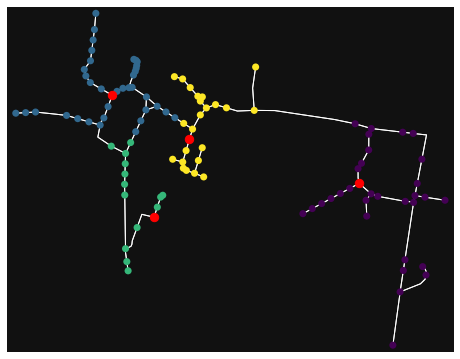

In [21]:
# medoids
import pandas as pd

nodes, edges = ox.graph_to_gdfs(simp_graph, nodes=True, edges=True)
nodes['cluster'] = labels
clu_graph = ox.graph_from_gdfs(nodes, edges)

cluster_graph = clu_graph.copy()

nc = ox.plot.get_node_colors_by_attr(cluster_graph, attr='cluster')
fig, ax = ox.plot_graph(cluster_graph, node_color=nc, node_size=50, edge_color='w', edge_linewidth=1, show=False, close=False)

for i in range(k):
    df_cluster = nodes[nodes['cluster'] == i]
    cluster_nodes = list(df_cluster.index)
    
    #cluster_loads = street_loads[street_loads.index.isin(cluster_nodes)]
    cluster_loads = pd.Series(cluster_nodes).map(street_loads.capacity).fillna(0).tolist()
    
    cluster_subgraph = cluster_graph.subgraph(cluster_nodes)
    dm_cluster = nx.floyd_warshall_numpy(cluster_graph, nodelist=cluster_nodes, weight='length')
    
    #load_vector = np.ones(len(cluster_nodes), dtype = int) #unweighted
    load_vector = np.array(cluster_loads) #weighted
    unweighted_nodes = dm_cluster.dot(load_vector)
    medoid = cluster_nodes[int(np.where(unweighted_nodes == np.amin(unweighted_nodes))[0][0])]
        
    medoid = cluster_graph.nodes[medoid]
    ax.scatter(medoid['x'],medoid['y'],s=70,c='red')
    
    print(medoid)
        
    print('\n')

In [24]:
dm_cluster

array([[  0.        ,  18.25770131,  27.96987111,  59.44713623,
         77.54010403,  70.19952572,  76.63506733,  91.63733787,
        108.6733206 , 137.75131644,  43.95929266,  59.78050884,
         60.78772267,  67.74982815,  69.17605969, 109.05383286,
        123.80134549, 129.35531794, 204.88006669,  18.22388318,
         38.85241877, 114.69432716,  89.11494628,  80.48405329],
       [ 18.25770131,   0.        ,  46.22757242,  41.18943492,
         59.28240272,  51.94182441,  58.37736602,  73.37963657,
         90.41561929, 119.49361513,  62.21699396,  78.03821015,
         79.04542398,  86.00752946,  87.433761  , 127.31153417,
        142.0590468 , 147.61301925, 223.137768  ,  36.48158449,
         20.59471746,  96.43662585, 107.37264759,  98.74175459],
       [ 27.96987111,  46.22757242,   0.        ,  87.41700734,
        105.50997514,  98.16939683, 104.60493844, 119.60720899,
        136.64319171, 165.72118755,  15.98942154,  31.81063773,
         32.81785156,  39.77995704,  4

In [23]:
load_vector

array([1.025082  , 2.050164  , 3.37811114, 0.        , 5.07363818,
       0.72480545, 0.72480545, 0.72480545, 0.66672   , 4.30400591,
       0.        , 0.        , 1.70847   , 0.        , 1.47549682,
       1.47549682, 2.95099364, 0.        , 0.        , 1.025082  ,
       1.025082  , 1.44961091, 2.95099364, 0.4271175 ])

In [22]:
unweighted_nodes

array([2617.80240724, 2611.83590332, 2741.62843389, 2809.48819226,
       3225.86536101, 2981.21433102, 3093.32523372, 3376.42102473,
       3918.62594376, 4441.7857318 , 2920.44363684, 3164.95292435,
       3406.60529949, 3429.21938541, 3310.15664445, 4161.8065609 ,
       4563.8015399 , 5663.51443831, 8167.95142764, 3184.75318818,
       2689.55077362, 3875.67971507, 3677.14207525, 4042.91979985])

In [ ]:
# todo check if truncate creates subgrpahs
# if len(subgraphs) > 1:
    # there are unconnected subgraphs
    # then for each subgraph
        # cluserting
        # for each cluster
            # build lv_grid_district

### Clustering

In [27]:
n_clusters = get_n_cluster(buildings_w_loads_df)
if n_clusters < len(fn_fallenbrunnen_la._lv_grid_districts):
    n_clusters = len(fn_fallenbrunnen_la._lv_grid_districts)
buildings_w_loads_df = cluster_k_means(buildings_w_loads_df, n_clusters)

In [29]:
n_clusters

3

### Update and add _districts

In [30]:
for i in range(n_clusters):
    
    print(len(buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==i)]))


99
85
79


In [28]:
buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0)]

,category,capacity,area,number_households,x,y,geometry,raccordement,nn,nn_dist,Cluster
osm_id,,,,,,,,,,,
8598838279,ice_cream,20.966863,229.121,0.645161,9.437183,47.674769,"POLYGON ((9.437094099999998 47.67477800001394,...",POINT (9.437183076702567 47.67476938145773),475940044,19.021132,0
144020300,public_building,244.695822,2113.09,0.8125,9.438239,47.675506,"POLYGON ((9.437905999999998 47.67551250001376,...",POINT (9.438238891069723 47.67550616796044),1576023053,34.831012,0
144023114,school,102.108142,1641.61,0.552632,9.438521,47.673818,"POLYGON ((9.438203599999998 47.67375600001416,...",POINT (9.438521488700175 47.67381754064048),68844093,33.677840,0
314909001,residential,1.246721,100,0.72973,9.43711,47.674319,"POLYGON ((9.4370154 47.67431780001401, 9.43711...",POINT (9.437109750000001 47.67431900001404),2080880814,14.638173,0
314909020,house,1.102239,100,0.645161,9.437548,47.674401,"POLYGON ((9.4374646 47.674413400014, 9.4375446...",POINT (9.437548450000001 47.67440130001403),314975344,15.374000,0
...,...,...,...,...,...,...,...,...,...,...,...
314913916,residential,2.904399,100,1.7,9.436301,47.672468,"POLYGON ((9.436173800000001 47.67246730001447,...",POINT (9.436301343479869 47.67246766666069),311379901,30.431139,0
338514542,school,407.558658,6552.39,0.594203,9.438414,47.673881,"POLYGON ((9.437957300000001 47.67387860001414,...",POINT (9.438414351486788 47.67388107322754),68844093,31.901109,0
401560706,residential,1.102239,100,0.645161,9.43769,47.674448,"POLYGON ((9.4376228 47.674467300014, 9.4377058...",POINT (9.437690147469656 47.67444791593603),314975344,27.030240,0


In [16]:
%%time

geometry = buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0), 'geometry'].tolist()

points = get_points_in_load_area(geometry)
        
len(points)

Wall time: 9.38 ms


140

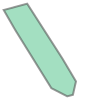

In [17]:
get_convex_hull_from_points(points)

In [24]:
fn_fallenbrunnen_la.lv_load_area_group.__dict__

{'id_db': 20,
 'mv_grid_district': mv_grid_district_40,
 '_lv_load_areas': [lv_load_area_4544,
  lv_load_area_4545,
  lv_load_area_4548,
  MVCableDist_mvgd_40_26],
 'peak_load': 65.35928151751943,
 'branch_length_sum': 0,
 'peak_load_max': 1000.0,
 'branch_length_max': 2000.0,
 'root_node': MVCableDist_mvgd_40_23}

In [28]:
nd._mv_grid_districts[0].__dict__

{'id_db': 40,
 'mv_grid': mv_grid_40,
 '_lv_load_areas': [lv_load_area_2128,
  lv_load_area_2292,
  lv_load_area_2383,
  lv_load_area_2520,
  lv_load_area_2521,
  lv_load_area_2561,
  lv_load_area_2608,
  lv_load_area_2625,
  lv_load_area_2633,
  lv_load_area_2705,
  lv_load_area_2728,
  lv_load_area_2763,
  lv_load_area_2765,
  lv_load_area_2840,
  lv_load_area_2842,
  lv_load_area_3029,
  lv_load_area_3088,
  lv_load_area_3089,
  lv_load_area_3119,
  lv_load_area_3160,
  lv_load_area_3235,
  lv_load_area_3277,
  lv_load_area_3304,
  lv_load_area_3305,
  lv_load_area_3307,
  lv_load_area_3311,
  lv_load_area_3314,
  lv_load_area_3403,
  lv_load_area_3413,
  lv_load_area_3645,
  lv_load_area_3661,
  lv_load_area_3731,
  lv_load_area_3780,
  lv_load_area_3805,
  lv_load_area_3911,
  lv_load_area_3986,
  lv_load_area_3987,
  lv_load_area_3992,
  lv_load_area_4212,
  lv_load_area_4337,
  lv_load_area_4347,
  lv_load_area_4487,
  lv_load_area_4488,
  lv_load_area_4544,
  lv_load_area_4545,

In [17]:
fn_fallenbrunnen_la._lv_grid_districts[0].lv_grid._station.__dict__

{'id_db': 4563,
 'geo_data': <shapely.geometry.point.Point at 0x118800eba90>,
 'grid': lv_grid_4563,
 '_transformers': [Transformer_lv_grid_4563_1],
 'v_level_operation': None,
 'lv_load_area': lv_load_area_4544,
 'voltage_res': [0.9897135909377942, 1.0123145234795161]}

In [17]:
preprocessed_clusters = []   
    

for cluster_id in range(n_clusters):
    
    if cluster_id < len(fn_fallenbrunnen_la._lv_grid_districts):
        
        print('delete or update _lv_grid_districts[', cluster_id, ']')
        
        # GET NEW VALUES FOR DISTRICT        
        # get convex hull of cluster
        points = get_points_in_load_area(buildings_w_loads_df.loc[buildings_w_loads_df['Cluster']==cluster_id])
        district_convex_hull = get_convex_hull_from_points(points)
        
        # get location of substation for cluster
        station_x, station_y = get_location_substation_at_pi(graph, buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0)])

        
        # UPDATE VALUES
        # update values of _lv_grid_districts[cluster_id]
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].geo_data  = district_convex_hull
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].poulation = buildings_w_loads_df.loc[buildings_w_loads_df['Cluster']==cluster_id]['number_households'].sum()
        
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].peak_load = buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0)]['capacity'].sum()
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].peak_load_residential = buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==cluster_id) & buildings_w_loads_df['number_households'] > 0]['capacity'].sum()
        
        
        # ADD / RESET DING0 ELEMENTS
        # update position of substation
        fn_fallenbrunnen_la._lv_grid_districts[0].lv_grid._station.geo_data = get_Point_from_x_y(station_x, station_y)
        
        # reset list to add new elements
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].lv_grid._station.transformers.clear()
        
        
        # update trafo and loads
        #fn_fallenbrunnen_la._lv_grid_districts[cluster_id].lv_grid.build_grid()
        
        
    else:
        
        print('add _lv_grid_districts id', cluster_id)
        
        
        
        
        
    break
    

update _lv_grid_districts 0
add _lv_grid_districts id 1
add _lv_grid_districts id 2


In [21]:
fn_fallenbrunnen_la._lv_grid_districts[0].lv_grid._station.__dict__

{'id_db': 4563,
 'geo_data': <shapely.geometry.point.Point at 0x1d50cd257f0>,
 'grid': lv_grid_4563,
 '_transformers': [Transformer_lv_grid_4563_1],
 'v_level_operation': None,
 'lv_load_area': lv_load_area_4544,
 'voltage_res': [0.9897135909377942, 1.0123145234795161]}

In [19]:
#lv_district_of_interest.lv_grid.graph_draw(mode='LV')

In [16]:
lv_district_of_interest.lv_grid.__dict__ # .geo_data.wkt

NameError: name 'lv_district_of_interest' is not defined

In [19]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

In [20]:
X = []    # collect nodes

for node in graph.nodes:

    X.append([graph.nodes[node]['X'], graph.nodes[node]['Y']])
    
    
X = np.array(X)



# clustering

adj_mat_sparse = nx.adjacency_matrix(graph, weight='length')

clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', connectivity=adj_mat_sparse).fit(X)






# assign cluster labels

i_label = 0

for node in list(graph.nodes):

    graph.nodes[node]['cluster'] = clustering.labels_[i_label]
    
    i_label += 1
    
labels = nx.get_node_attributes(graph, 'cluster') 

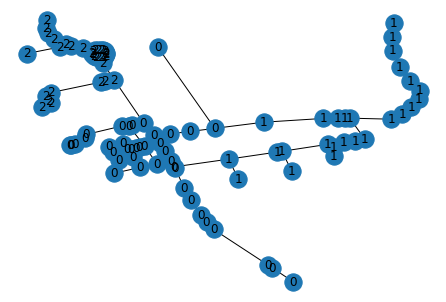

In [23]:
nx.draw(graph, node_coords_dict,labels=labels)

In [24]:
X = []    # collect nodes

for node in graph.nodes:

    X.append([graph.nodes[node]['X'], graph.nodes[node]['Y']])
    
    
X = np.array(X)



# clustering

adj_mat_sparse = nx.to_numpy_matrix(graph, weight='length')

clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', connectivity=adj_mat_sparse).fit(X)






# assign cluster labels

i_label = 0

for node in list(graph.nodes):

    graph.nodes[node]['cluster'] = clustering.labels_[i_label]
    
    i_label += 1
    
labels = nx.get_node_attributes(graph, 'cluster') 

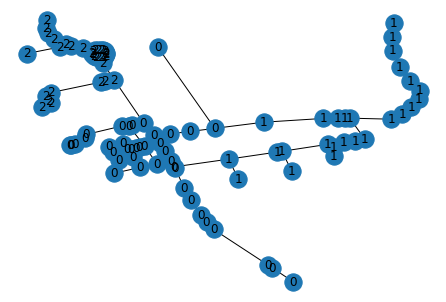

In [25]:
nx.draw(graph, node_coords_dict,labels=labels)